In [1]:
import pickle
import pandas as pd

from glob import glob

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
from sklearn.metrics import mean_squared_log_error, median_absolute_error

def result_dataframe(path, dataset_name):

    model_directories = glob(path + f"/{dataset_name}/*/")

    table_dict = {}

    for idx in range(len(model_directories)):
        directory = model_directories[idx]
        model_name = directory.split("/")[-2]
        station_pkls = glob(path + f"/{dataset_name}/" + model_name + "/*_pm25.pkl")
        
        if model_name == 'TSTransformer':
            model_name = 'PolTrans'

        model_data = {}

        for inner_idx in range(len(station_pkls)):
            station_data = pickle.load(open(station_pkls[inner_idx], "rb"))
            station_data['score']['medae'] = median_absolute_error(station_data['test_set'], 
                                                                   station_data['test_set_predictions'])
            model_data[station_data["station_id"]] = station_data["score"]
            del model_data[station_data["station_id"]]['r2_score']
            
        table_dict[model_name] = model_data

    reform = {(outerKey, innerKey): values for outerKey, innerDict in table_dict.items() for innerKey, values in innerDict.items()}

    result_df = pd.DataFrame(reform).transpose()
    
    return result_df

In [4]:
path = "./dl_models"
dataset_directories = glob(path + f"/*/")

result_df_list = []

for ds_dir in dataset_directories:
    dataset_name = ds_dir.split("/")[-2]
    result_df = result_dataframe(path, dataset_name)    
    result_df_list.append([dataset_name, result_df])

In [5]:
path = "./tstrans_models"
dataset_directories = glob(path + f"/*/")

for idx, ds_dir in enumerate(dataset_directories):
    dataset_name = ds_dir.split("/")[-2]
    result_df = result_dataframe(path, dataset_name)    
    result_df_list[idx][1] = pd.concat([result_df_list[idx][1], result_df], axis=0)

In [6]:
result_df_list.sort(key=lambda x: x[0])

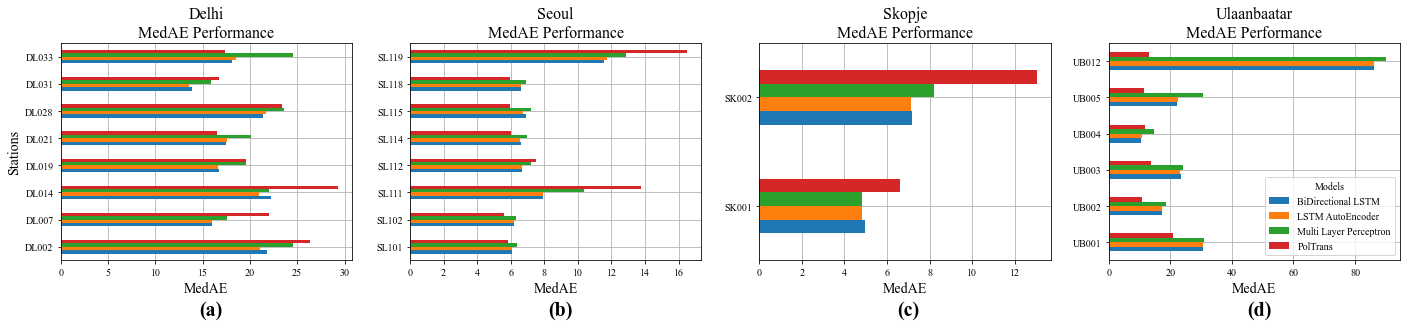

In [7]:
import matplotlib.pyplot as plt
import string

plt.rcParams["font.family"] = "Times New Roman"

fig, axs = plt.subplots(ncols=len(result_df_list), figsize=(6*len(result_df_list), 4))

for idx in range(len(result_df_list)):
    
    ax = axs[idx]

    df = result_df_list[idx][1].swaplevel(0)[['medae']].reset_index().pivot(index='level_0', columns='level_1')
    df.columns = df.columns.droplevel(0)
    df.columns.name = "Models"
    df.index.name = "Stations"
    
    dataset_name = result_df_list[idx][0]

    df.plot.barh(ax=ax, zorder=2)
    ax.grid(ls='-',zorder=1)
    ax.set_title(f'{dataset_name.capitalize()}\nMedAE Performance', fontsize=16)
    ax.set_xlabel('MedAE', fontsize=14)
    ax.set_ylabel('', fontsize=14)
    
    if idx == 0:
        ax.set_ylabel('Stations', fontsize=14)
    
    if idx != (len(result_df_list) - 1):
        ax.get_legend().remove()
        
    
    ax.text(0.475, -0.25, f"({string.ascii_lowercase[idx]})", transform=axs[idx].transAxes, 
            size=20, weight='bold')
    

plt.savefig(f"./paper_figures/dl_medae.png", dpi=300, bbox_inches='tight')   

In [8]:
table_df = pd.DataFrame()

for idx in range(len(result_df_list)):
    dataset_name = result_df_list[idx][0]
    
    df = result_df_list[idx][1].reset_index()
    df = df.drop(['level_1'], axis=1)
    df = df.groupby('level_0').mean()
    df = df.drop('mean', axis=1)
    df.index.name = 'Model'
    df['city'] = dataset_name.capitalize()
    
    df = df.reset_index().set_index(['city', 'Model'])
    table_df = pd.concat([table_df, df])

In [9]:
table_df = table_df.round(3)
print(table_df.to_latex())

\begin{tabular}{llrrr}
\toprule
            &          &     mae &    rmse &   medae \\
city & Model &         &         &         \\
\midrule
Delhi & BiDirectional LSTM &  31.958 &  49.658 &  18.439 \\
            & LSTM AutoEncoder &  31.900 &  49.477 &  18.253 \\
            & Multi Layer Perceptron &  34.017 &  51.746 &  20.956 \\
            & PolTrans &  33.114 &  49.020 &  21.426 \\
Seoul & BiDirectional LSTM &  10.891 &  21.716 &   7.312 \\
            & LSTM AutoEncoder &  10.869 &  21.538 &   7.305 \\
            & Multi Layer Perceptron &  11.181 &  20.936 &   8.017 \\
            & PolTrans &  11.855 &  22.597 &   8.398 \\
Skopje & BiDirectional LSTM &  11.491 &  19.416 &   6.086 \\
            & LSTM AutoEncoder &  11.539 &  19.450 &   5.973 \\
            & Multi Layer Perceptron &  11.726 &  18.942 &   6.533 \\
            & PolTrans &  14.435 &  22.126 &   9.820 \\
Ulaanbaatar & BiDirectional LSTM &  43.269 &  64.750 &  31.713 \\
            & LSTM AutoEncoder &  43.344